## Simulation of raising interest rate multiplier


The latest proposal has increased the interest rates for all crvUSD markets. We attempt to explain this as follows, assuming pegkeeper_filling = 0. According to the formula:

```python
rate = rate0 * exp(depeg / sigma) * exp(- pegkeeper_filling / (total_debt * target_f))
```

The lending rate of crvUSD is positively correlated with price depeg. Assuming that the market can sustain a maximum rate r_max, and the final stable rate and the maximum borrowing amount are fixed.

When a depeg occurs, the current rate r_now > rate0, and during a significant depeg, r_now > r_normal.

From the formula, it's seen that increasing rate0 to rate0' results in a smaller depeg at the normal rate r_normal. In other words, increasing rate0 heightens the sensitivity of the rate to depeg. Conversely, a lower depeg leads to a higher rate.

Raising rate0 allows the rate to reach the maximum value r_max quicker, thus promoting the repayment and destruction of crvUSD and reducing depeg in the crvUSD pool.

We simulated scenarios where depeg varies from 0 to its maximum (users borrow more crvUSD and add it to the crvUSD pool, sustaining the depeg) and from the maximum back to 0 (users start buying back crvUSD and redeeming assets for crvUSD destruction as the rates gradually increase to the sustainable limit).

With rate0 set at 5%, 10%, and 15%, we found that increasing rate0 does not impose additional costs on users. Furthermore, it has three main advantages:

1. It results in a more minor degree of price de-anchoring and a quicker return to a depeg=0 state.
2. It allows users to reach their maximum borrowing amount of crvUSD earlier.
3. It causes the interest rate to rise to r_max sooner.

In [1]:
from collections import defaultdict
from copy import deepcopy
import crvusdsim
from crvusdsim.pool import SimMarketInstance
import numpy as np
import pandas as pd

In [2]:
market_name = "wstETH"
sim_market = crvusdsim.pool.get(market_name)


In [5]:
class LoanUser:
    def __init__(
        self,
        address,
        controller,
        stableswap_pools,
        collateral_amount=10 * 10**18,
        N=10,
        ema_tvl=[1, 1, 1, 1],
    ):
        self.address = address
        self.controller = controller
        self.borrowed_token = self.controller.STABLECOIN
        self.collateral_token = controller.COLLATERAL_TOKEN
        self.stableswap_pools = stableswap_pools
        self.collateral_amount = collateral_amount
        self.N = N

        sum_tvl = sum(ema_tvl)

        self.initial_debt = int(controller.max_borrowable(collateral_amount, N) * 0.90)
        self.has_debt = False
        self.create_loan_timestamp = 0
        self.interest_avg_ratio = 0
        self.ema_tvl = [t / sum_tvl for t in ema_tvl]

    def update(self, rate):
        if rate < self.max_ratio:
            if not self.has_debt:
                self.create_loan_and_exchange()
        else:
            if self.has_debt:
                self.repay()

    def create_loan_and_exchange(self):
        self.collateral_token._mint(self.address, self.collateral_amount)
        self.controller.create_loan(
            self.address, self.collateral_amount, self.initial_debt, self.N
        )
        self.initial_debt = self.controller.debt(self.address)
        # sell crvUSD from stableswap pools
        pool_count = len(self.stableswap_pools)
        amount_in = self.borrowed_token.balanceOf[self.address]
        for i in range(pool_count):
            spool = self.stableswap_pools[i]
            spool.exchange(
                1,
                0,
                min(
                    int(amount_in * self.ema_tvl[i]),
                    self.borrowed_token.balanceOf[self.address],
                ),
                _receiver=self.address,
            )

        self.create_loan_timestamp = self.controller._block_timestamp
        self.has_debt = True

    def repay(self):
        if not self.has_debt:
            return

        repay_amount = self.controller.debt(self.address)

        if repay_amount < 10**6:
            self.has_debt = False
            return

        # buy crvUSD from stableswap pools
        buy_amount = repay_amount - self.borrowed_token.balanceOf[self.address]
        if buy_amount > 0:
            for i in range(len(self.stableswap_pools)):
                spool = self.stableswap_pools[i]
                dx = spool.get_dx(0, 1, int(buy_amount * self.ema_tvl[i]))
                spool.coins[0]._mint(self.address, dx + 1)
                spool.exchange(0, 1, dx + 1, _receiver=self.address)

        # repay to controller
        self.controller.repay(repay_amount, self.address)

        if self.controller.debt(self.address) < 10**6:
            self.has_debt = False


class Market:
    def __init__(
        self,
        sim_market: SimMarketInstance,
    ) -> None:
        (
            new_pool,
            new_controller,
            new_collateral_token,
            new_stablecoin,
            new_aggregator,
            new_price_oracle,
            new_stableswap_pools,
            new_peg_keepers,
            new_policy,
            new_factory,
        ) = sim_market.copy()

        # reset stableswap pool balances and price
        for pool in new_stableswap_pools:
            s = 0
            for i in range(len(pool.balances)):
                s += pool.balances[i] * pool.rates[i] // 10**18
            for i in range(len(pool.balances)):
                balance = s // 2 * 10**18 // pool.rates[i]
                pool.balances[i] = balance
                pool.coins[i].balanceOf[pool.address] = balance
                pool.last_price = 10**18
                pool.ma_price = 10**18

        self.pool = new_pool
        self.controller = new_controller
        self.collateral_token = new_collateral_token
        self.stablecoin = new_stablecoin
        self.aggregator = new_aggregator
        self.stableswap_pools = new_stableswap_pools
        self.peg_keepers = new_peg_keepers
        self.policy = new_policy
        self.factory = new_factory

        # set controller debt ceiling to prepare enough crvUSD
        self.factory.set_debt_ceiling(
            self.controller.address,
            sum([stablepool.totalSupply for stablepool in self.stableswap_pools]),
        )

        self.users = []
        self.total_debt = 0
        self.state_logs = []
        self.initial_collateral = 0
        self.max_annualized_rate = 0.20
        self.max_rate = (1 + 0.20) ** (1 / (365 * 86400)) - 1
        self.repay_delay = 1 * 24 * 60 * 60
        self.close_position_time = -1
        self.duration = 0
        self.params = {}

    def init(self, rate0, sigma, target_f, max_rate, initial_collateral):
        self.params = {
            "rate0": rate0,
            "sigma": sigma,
            "target_f": target_f,
        }
        self.max_annualized_rate = max_rate
        self.max_rate = ((1 + max_rate) ** (1 / (365 * 86400)) - 1) * 10**18
        # The rate0 in the code will convert the annualized rate to the rate per second
        self.policy.rate0 = int(((1 + rate0) ** (1 / (365 * 86400)) - 1) * 1e18)
        self.policy.sigma = int(sigma * 10**18)
        self.policy.target_debt_fraction = int(target_f * 10**18)
        self.initial_collateral = initial_collateral
        self.total_debt = self.controller.total_debt()

        rate_mul = self.controller._rate_mul_w()

        print(
            "init collateral_amount",
            self.initial_collateral / 1e18,
            "annualized_rate",
            self.get_annualized_rate(),
        )

    def _increment_blockts(self, delta_t):
        self.pool._increment_timestamp(timedelta=delta_t)
        self.pool.price_oracle_contract._increment_timestamp(timedelta=delta_t)
        self.controller._increment_timestamp(timedelta=delta_t)
        self.aggregator._increment_timestamp(timedelta=delta_t)
        for pk in self.peg_keepers:
            pk._increment_timestamp(timedelta=delta_t)
        for stablepool in self.stableswap_pools:
            stablepool._increment_timestamp(timedelta=delta_t)

    def get_annualized_rate(self):
        return (1 + self.policy.rate(self.controller) / 1e18) ** (365 * 86400) - 1

    def process_by_dt(self, dt):
        self._increment_blockts(delta_t=dt)
        self.controller._rate_mul_w()

        if self.close_position_time < 0:
            rate = self.policy.rate(self.controller)
            if rate > self.max_rate:
                self.close_position_time = self.duration + self.repay_delay

        if self.close_position_time < 0:
            user = LoanUser(
                "user_address_%d" % (self.controller._block_timestamp),
                self.controller,
                self.stableswap_pools,
                collateral_amount=self.initial_collateral,
                ema_tvl=self.aggregator.ema_tvl(),
            )
            user.create_loan_and_exchange()
            self.users.append(user)
        else:
            if self.duration > self.close_position_time:
                if len(self.users) > 0:
                    user = self.users.pop()
                    user.repay()

        self.duration += dt
        self.update_log()

    def update_log(self):
        pk_debt = sum([pk.debt for pk in self.peg_keepers])
        total_debt = self.factory.total_debt()
        pegkeeper_filling = pk_debt / total_debt if total_debt > 0 else 0
        stableswap_price = (
            np.mean([spool.get_p() for spool in self.stableswap_pools]) / 1e18
        )

        self.state_logs.append(
            {
                "timestamp": self.pool._block_timestamp,
                "duration": self.duration,
                "agg_price": self.aggregator.price() / 1e18,
                "stableswap_price": stableswap_price,
                "annualized_rate": min(
                    self.max_annualized_rate, self.get_annualized_rate()
                ),
                "pk_debt": pk_debt / 1e18,
                "total_debt": total_debt / 1e18,
                "pegkeeper_filling": pegkeeper_filling,
                "users_count": len(self.users),
            }
        )

In [6]:
# rate = rate0 if PegKeepers are empty, lower when at target fraction
rate0s = [0.05, 0.10, 0.15]
sigma = 0.02  # 2%
target_f = 0.10  # target fraction 10%
# Assume annualized rate greater than `max_annualized_rate`,
# user will repay their debt
max_annualized_rate = 0.20


def sim():
    start_agg_p = 10**18

    markets = []
    for rate0 in rate0s:
        market = Market(sim_market)
        # Assume users will `create_loan` if annualized rate
        # lower than `max_annualized_rate`
        users_count = 1000
        users_address = ["user_address_%d" % i for i in range(users_count)]
        collateral_price = market.pool.get_p() / 1e18
        initial_collateral = (
            sum([spool.totalSupply for spool in market.stableswap_pools])
            / collateral_price
            // users_count
        )
        market.init(rate0, sigma, target_f, max_annualized_rate, initial_collateral)
        market.update_log()
        markets.append(market)

    dt_interval = 5 * 60  # seconds
    sim_count = 5 * 24 * 60 * 60 // dt_interval
    for i in range(sim_count):
        for m in markets:
            m.process_by_dt(dt=dt_interval)

    return markets


markets = sim()

init collateral_amount 34.099982216916985 annualized_rate 0.05000000082842315
init collateral_amount 34.099982216916985 annualized_rate 0.10000000044843893
init collateral_amount 34.099982216916985 annualized_rate 0.1499999960358993


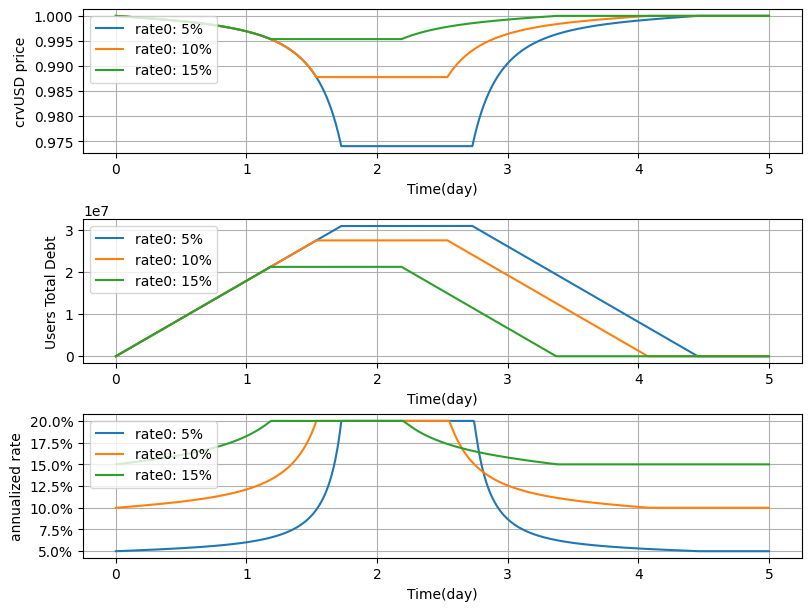

In [7]:
%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, layout='constrained', figsize=(8, 6))

time_series = [log["duration"] / (24 * 60 * 60) for log in markets[0].state_logs]

for m in markets:
    label = "rate0: %.0f%%" % (m.params["rate0"] * 100)
    stableswap_price = [log["stableswap_price"] for log in m.state_logs]
    total_debt = [log["total_debt"] for log in m.state_logs]
    rates_list = [log["annualized_rate"] for log in m.state_logs]

    ax1.plot(time_series, stableswap_price, label=label)
    ax2.plot(time_series, total_debt, label=label)
    ax3.plot(time_series, rates_list, label=label)

# ax1.set_title("rate0 compare")
ax1.set_xlabel('Time(day)')
ax1.set_ylabel('crvUSD price')
ax1.grid(True)
ax1.locator_params(axis='y', nbins=6)
ax1.yaxis.set_major_formatter(mtick.FormatStrFormatter("%.3f"))
ax1.legend(loc='upper left')

ax2.set_xlabel('Time(day)')
ax2.set_ylabel('Users Total Debt')
ax2.grid(True)
ax2.legend(loc='upper left')

ax3.set_xlabel('Time(day)')
ax3.set_ylabel('annualized rate')
ax3.grid(True)
ax3.locator_params(axis='y', nbins=8) 
ax3.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax3.legend(loc='upper left')

plt.show()
